In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import pandas as pd

In [3]:
import lib
import plotting
import markov_chain as mc
import markov_tools as mt

In [4]:
from configparser import ConfigParser
cfg = ConfigParser()
cfg.read("config.cfg")

['config.cfg']

In [5]:
from tqdm._tqdm_notebook import tqdm_notebook as tqdm # we manually import the notebook submodule as the normal one struggles with jupyterlab
tqdm.pandas() # this enables us to use progress_apply instead of apply

In [12]:
sequence_file = os.path.join(cfg.get("directory", "exchange"), "[wikidata]004_sequences.p")
labels_file = os.path.join(cfg.get("directory", "exchange"), "[wikidata]004_labels_readable.p")
results_prefix = "[WIKIDATA_PAPER]"

In [7]:
df = pd.read_pickle(sequence_file)
labels = pd.read_pickle(labels_file)['label'].values
df.head()

,bot_name,bot_sequence,length,length_nobreak,sequence,sequence_readable,user_id,user_name
0,False,False,1517,1385,"[REVERT_MANUAL, BREAK, CLAIM_CREATE, BREAK, CL...","[Revert Item, Break, Create Claim, Break, Crea...",1,Hoo man
1,False,False,9,6,"[ENTITY_CREATE, BREAK, SITELINK_ADD, BREAK, ME...","[Create Item, Break, Add Sitelink, Break, Merg...",1000036,JShenk
2,False,False,7,4,"[SITELINK_ADD, BREAK, SITELINK_ADD, BREAK, SIT...","[Add Sitelink, Break, Add Sitelink, Break, Add...",1000078,Egor-belikov
3,False,False,9,6,"[ENTITY_CREATE, BREAK, SITELINK_REMOVE, SITELI...","[Create Item, Break, Remove Sitelink, Add Site...",100008,Wars
4,False,False,44,23,"[SITELINK_ADD, BREAK, SITELINK_ADD, BREAK, SIT...","[Add Sitelink, Break, Add Sitelink, Break, Add...",100012,Kane 14


In [8]:
labels

array(['Add Description', 'Add Item Alias', 'Add Label', 'Add Qualifier',
       'Add Reference', 'Add Sitelink', 'Break', 'Create Claim',
       'Create Item', 'Create Property', 'Edit Alias', 'Edit Claim',
       'Edit Claim Value', 'Edit Description', 'Edit Item', 'Edit Label',
       'Edit Qualifier', 'Edit Reference', 'Edit Sitelink', 'Merge Items',
       'Override Item', 'Protect Item', 'Redirect Item', 'Remove Alias',
       'Remove Claim', 'Remove Description', 'Remove Item',
       'Remove Label', 'Remove Qualifier', 'Remove Reference',
       'Remove Sitelink', 'Revert Item'], dtype=object)

In [9]:
null_model = 5

In [10]:
sequence = df['sequence_readable'].values

In [11]:
plot_data = dict()
parameters = {}
likelihoods = {}
observations = {}

for order in tqdm(range(0, null_model + 1)):
    markov_chain = mc.MarkovChain(k=order, use_prior=False, reset=True, modus="mle")
    markov_chain.prepare_data(sequence)
    matrix = markov_chain.fit(sequence, ret=True)
    likelihoods[order] = markov_chain.loglikelihood()
    print(order, likelihoods[order])
    parameters[order] = markov_chain.parameter_count_
    observations[order] = markov_chain.observation_count_

    del markov_chain


lrts, pvals, dfs = mt.likelihood_ratio_test(likelihoods, parameters)
aics = mt.akaike_information_criterion(lratios=lrts, dfs=dfs, null_model=null_model)
bics = mt.bayesian_information_criterion(lratios=lrts, dfs=dfs, obs=observations, null_model=null_model)
print("#" * 30)
print("AICS", aics)
print("min index:", min(aics, key=aics.get))
print("BICS", bics)
print("min index:", min(bics, key=bics.get))
print("#" * 30)
plot_data[0] = {"aics": aics, "bics": bics}

0 -179522601.44861713
1 -108564185.96460356
2 -85468160.66936266
3 -73853096.72153923
4 -67571955.3620002
5 -61697101.856030315

##############################
AICS {0: -2269014088.8148265, 1: -2410928871.7828536, 2: -2457053338.3733354, 3: -2478053194.268982, 4: -2417016500.98806, 5: 0.0}
min index: 3
BICS {0: -22500863714.734623, 1: -22642761954.64137, 2: -22688340500.20965, 3: -22691324962.37258, 4: -22035780275.912144, 5: 0.0}
min index: 3
##############################


In [13]:
store_path = os.path.join(cfg.get("directory", "results"), results_prefix + "information_criterion")

TypeError: 'AxesSubplot' object does not support indexing

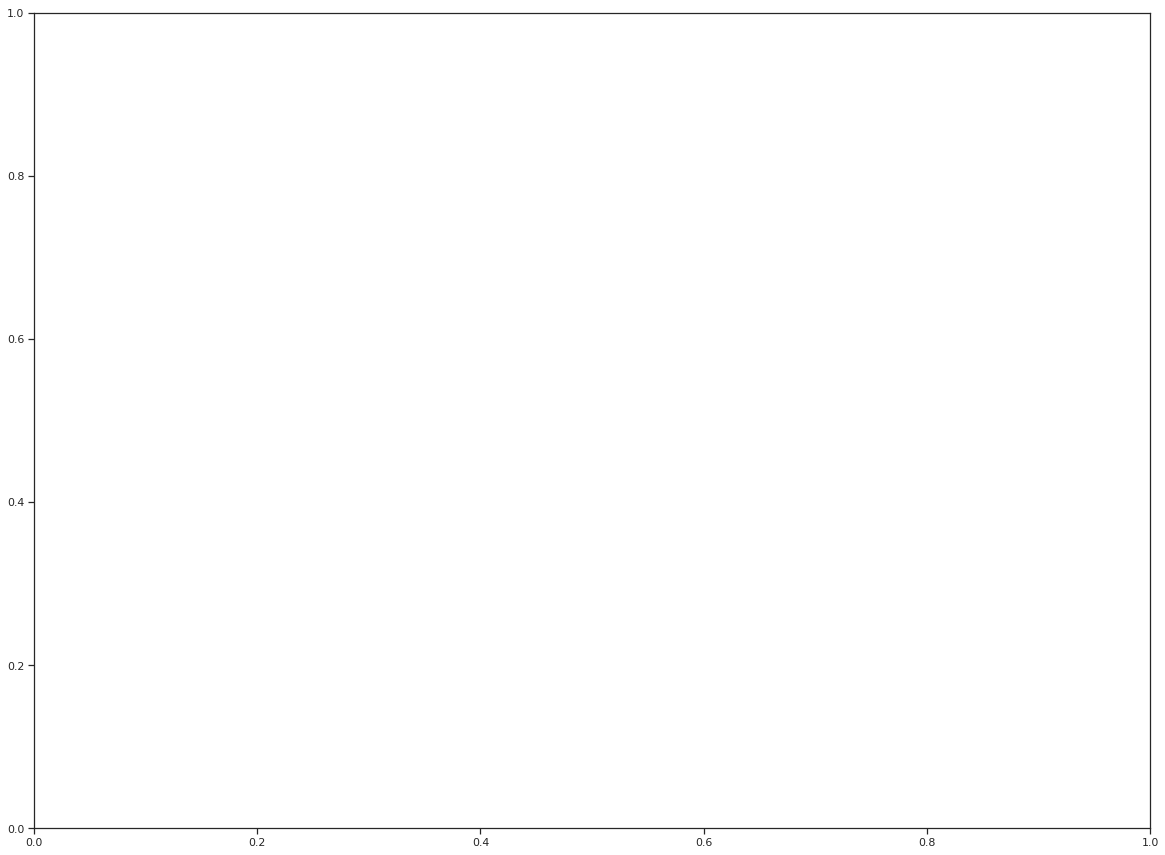

In [14]:
plotting.aics_bics(plot_data, store_path)